In [4]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
df = pd.read_excel('^IXIC.xlsx')

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)
TRAIN_SPLIT = 0.7
tf.random.set_seed(13)

Date
2012-01-03    0.000000
2012-01-04   -0.000136
2012-01-05    0.008085
2012-01-06    0.001632
2012-01-09    0.000875
Name: Log return ^IXIC, dtype: float64


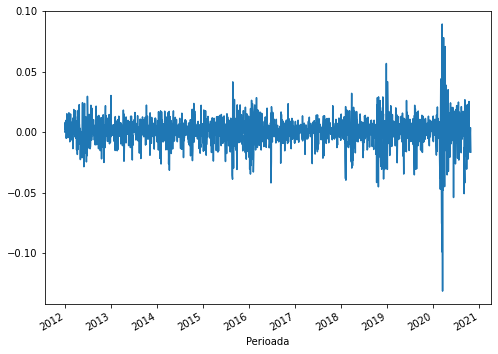

In [6]:
#Predictia seriei de timp univariate
uni_data = df['Log return ^IXIC']
uni_data.index = df['Date']
print(uni_data.head())

uni_data.plot(subplots=True)
plt.xlabel('Perioada')
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

uni_data_train, uni_data_test = train_test_split(uni_data, train_size=0.7, test_size=0.3, shuffle=False)
uni_data = uni_data.values

In [8]:
uni_train_mean = uni_data_train.mean()
uni_train_std = uni_data_train.std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

univariate_past_history = 100
univariate_future_target = 10

x_train_uni, y_train_uni = univariate_data(uni_data, 0, len(uni_data_train),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, len(uni_data_train), None,
                                       univariate_past_history,
                                       univariate_future_target)

print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[-0.07348581]
 [-0.08851077]
 [ 0.82061527]
 [ 0.10694559]
 [ 0.02323662]
 [ 0.99305647]
 [ 0.26398337]
 [ 0.49371613]
 [-0.64436282]
 [ 0.63448796]
 [ 1.60121585]
 [ 0.66743958]
 [-0.13815335]
 [-0.17392766]
 [ 0.02457277]
 [ 1.17618416]
 [-0.58592771]
 [-0.2546329 ]
 [ 1.27136873]
 [ 0.3686084 ]
 [ 1.69037857]
 [-0.2132412 ]
 [ 0.0061291 ]
 [ 0.37416621]
 [ 0.35686804]
 [-0.95911498]
 [ 0.96918   ]
 [-0.05688185]
 [-0.67861912]
 [ 1.58347532]
 [-0.37539918]
 [-0.19380479]
 [-0.65255724]
 [ 0.82053699]
 [ 0.17940146]
 [ 0.01639464]
 [ 0.69185185]
 [-0.81161242]
 [ 0.74643184]
 [-0.54731579]
 [-1.03289863]
 [-1.58898169]
 [ 0.88629835]
 [ 1.22704347]
 [ 0.5916335 ]
 [-0.24680816]
 [ 1.99077019]
 [-0.04256622]
 [ 0.49383705]
 [-0.1136575 ]
 [ 0.75801088]
 [-0.22339078]
 [-0.03140134]
 [-0.50582215]
 [ 0.09243768]
 [ 1.87900815]
 [-0.1521309 ]
 [-0.62024299]
 [-0.41590884]
 [-0.20896751]
 [ 0.92813328]
 [-0.29098042]
 [-1.70066392]
 [ 0.37289536]
 [-1.27972

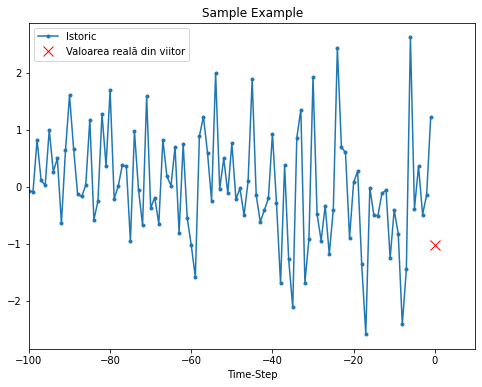

In [9]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['Istoric', 'Valoarea reală din viitor', 'Predicția modelului']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

    plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plt.show()

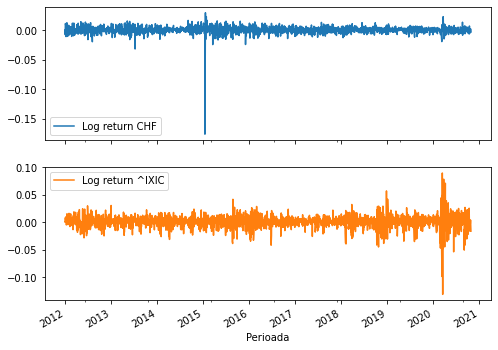

In [11]:
#Forecast a multivariate time series

features_considered = ['Log return CHF', 'Log return ^IXIC']
features = df[features_considered]
features.index = df['Date']
features.head()

features.plot(subplots=True)
plt.xlabel('Perioada')
plt.show()

In [12]:
multi_data_train, multi_data_test = train_test_split(features, train_size=0.7, test_size=0.3, shuffle=False)

dataset = features.values
data_mean = dataset[:len(multi_data_train)].mean(axis=0)
data_std = dataset[:len(multi_data_train)].std(axis=0)

In [13]:
dataset = (dataset-data_mean)/data_std

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

past_history = 100
future_target = 10
STEP = 1
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   len(multi_data_train), past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               len(multi_data_train), None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print ('Single window of past history : {}'.format(x_train_single[0].shape))

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Single window of past history : (100, 2)
(256, 1)
Epoch 1/100
200/200 [==============================] - 16s 70ms/step - loss: 0.7180 - val_loss: 1.2512
Epoch 2/100
200/200 [==============================] - 13s 67ms/step - loss: 0.7120 - val_loss: 1.2553
Epoch 3/100
200/200 [==============================] - 13s 67ms/step - loss: 0.7021 - val_loss: 1.2638
Epoch 4/100
200/200 [==============================] - 13s 67ms/step - loss: 0.6932 - val_loss: 1.2795
Epoch 5/100
200/200 [==============================] - 13s 66ms/step - loss: 0.6845 - val_loss: 1.2810
Epoch 6/100
200/200 [==============================] - 13s 65ms/step - loss: 0.6760 - val_loss: 1.2741
Epoch 7/100
200/200 [==============================] - 13s 66ms/step - loss: 0.6688 - val_loss: 1.2731
Epoch 8/100
200/200 [==============================] - 13s 66ms/step - loss: 0.6602 - val_loss: 1.2783
Epoch 9/100
200/200 [==============================] - 13s 65ms/step - loss: 0.6528 - val_loss: 1.2815
Epoch 10/100
200/200 [=

In [14]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Pierderea setului de testare')
  plt.plot(epochs, val_loss, 'r', label='Pierderea setului de validare')
  plt.title('Capacitatea de generalizare a modelului')
  plt.legend()

  plt.show()
plt.show()

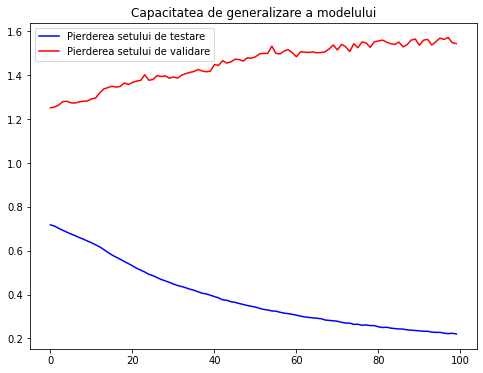

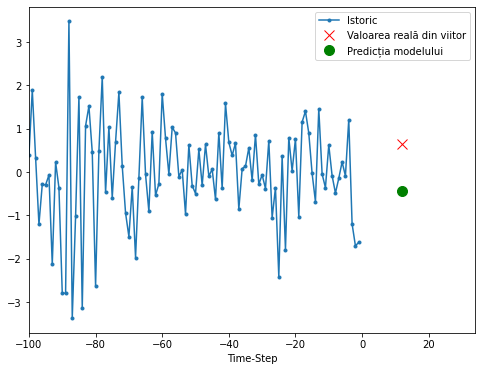

In [15]:
plot_train_history(single_step_history,
                   'Predicția într-o singură etapă')

for x, y in val_data_single.take(1):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()
plt.show()

In [16]:
#Multi-Step model

future_target = 5
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 len(multi_data_train), past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             len(multi_data_train), None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (100, 2)

 Target temperature to predict : (5,)


In [17]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

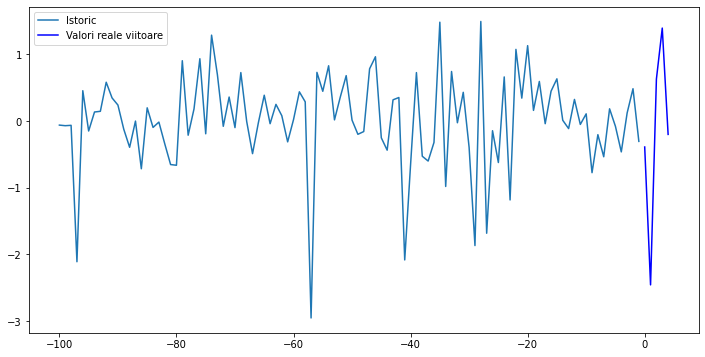

In [18]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='Istoric')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b',
           label='Valori reale viitoare')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
plt.show()

for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))
plt.show()


(256, 5)
Epoch 1/100
200/200 [==============================] - 33s 143ms/step - loss: 0.7205 - val_loss: 1.2323
Epoch 2/100
200/200 [==============================] - 30s 149ms/step - loss: 0.7155 - val_loss: 1.2341
Epoch 3/100
200/200 [==============================] - 28s 139ms/step - loss: 0.7047 - val_loss: 1.2640
Epoch 4/100
200/200 [==============================] - 28s 139ms/step - loss: 0.7221 - val_loss: 254.3967
Epoch 5/100
200/200 [==============================] - 27s 135ms/step - loss: 0.6819 - val_loss: 5.8536
Epoch 6/100
200/200 [==============================] - 29s 145ms/step - loss: 0.6615 - val_loss: 1.2560
Epoch 7/100
200/200 [==============================] - 28s 140ms/step - loss: 0.6494 - val_loss: 1.3079
Epoch 8/100
200/200 [==============================] - 27s 133ms/step - loss: 0.6425 - val_loss: 1.3146
Epoch 9/100
200/200 [==============================] - 27s 134ms/step - loss: 0.6369 - val_loss: 1.3603
Epoch 10/100
200/200 [==============================]

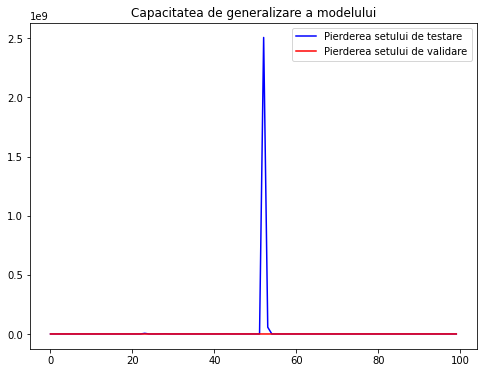

In [19]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

plot_train_history(multi_step_history, 'Capacitatea de învățare a modelului')


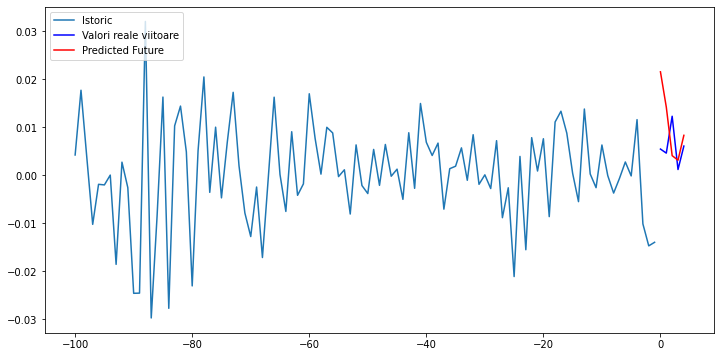

0.009248113860792708


In [20]:
#Predict a multi-step future

predicted=(multi_step_model.predict(x)[0])*data_std[1]+data_mean[1]
history=(x[0])*data_std[1]+data_mean[1]
true_future=(y[0])*data_std[1]+data_mean[1]

for x, y in val_data_multi.take(1):
  multi_step_plot(history, true_future, predicted)


from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(true_future, predicted))
print(rmse)